## Problem statement

#### To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import math
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, Activation, MaxPool2D, concatenate, BatchNormalization
from tensorflow.keras import optimizers, losses, metrics

## 1. Data Reading/Understanding

### Importing Skin Cancer Data

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

In [3]:
# Defining the path for train and test images

train_folder_path = "Train"
test_folder_path = "Test"

data_dir_train = pathlib.Path(train_folder_path)
data_dir_test = pathlib.Path(test_folder_path)

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("\033[1mTraining\033[0m dataset contains \033[1m{0}\033[0m images".format(image_count_train))
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("\033[1mTest\033[0m dataset contains \033[1m{0}\033[0m images".format(image_count_test))

Training dataset contains 2239 images
Test dataset contains 118 images


## 2. Dataset Creation

We will be creating ***train*** & ***validation*** dataset from the ***train directory***.

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Creating a dataset

Defining some parameters for the loader:

In [5]:
batch_size = 32

Using ***seed=123*** while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory

In [6]:
seed = 123

Parameters for ***resizing*** the images

In [7]:
img_height = 180
img_width = 180

Using ***80%*** of the images for ***training***, and ***20%*** for ***validation***.

In [8]:
validation_split = 0.2  # Train and test split

Removing any augmentor images from previous runs

In [9]:
import glob, os, shutil
dirs = data_dir_train.glob("*/output")
for dir in dirs:
    shutil.rmtree(dir)

In [10]:
## Creating our train dataset here
## Resizing train images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, 
                                                           batch_size=batch_size,
                                                           image_size=(img_height, img_width),
                                                           seed=seed,
                                                           validation_split=validation_split,
                                                           subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


2022-07-20 22:31:24.785835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 22:31:24.810576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 22:31:24.810834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 22:31:24.811496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [11]:
## Validation Dataset
## Resizing validation images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, 
                                                           batch_size=batch_size,
                                                           image_size=(img_height, img_width),
                                                           seed=seed,
                                                           validation_split=validation_split,
                                                           subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
print("We got \033[1mTraining Dataset\033[0m containing \033[1m{0} images\033[0m".format(math.ceil(image_count_train*(1-validation_split))))
print("We got \033[1mValidation Dataset\033[0m containing \033[1m{0} images\033[0m".format(math.floor(image_count_train*(validation_split))))

We got Training Dataset containing 1792 images
We got Validation Dataset containing 447 images


In [13]:
# Listing out all the classes of skin cancer and storing them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [14]:
class_count = len(class_names)
print("We got \033[1m{0} classes\033[0m which our model will be classifying".format(class_count))

We got 9 classes which our model will be classifying


## 3. Data Visualization

#### Visualizing one instance of all the nine classes present in the dataset

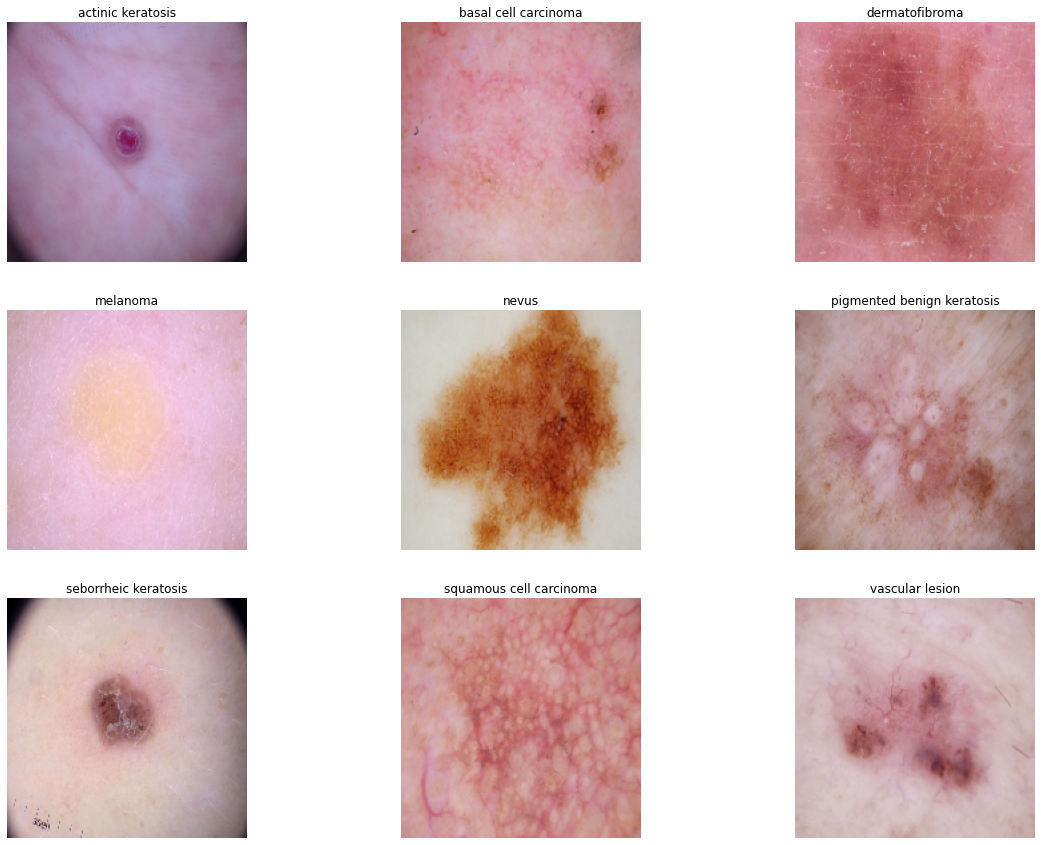

In [15]:
plt.figure(figsize=(20, 15))  # Setting canvas size so we can observe all images easily
for images, labels in train_ds.take(1):
    for i,label in enumerate(class_names):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(label)
        plt.axis('off')

### Checking shapes of tensors

In [16]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


As seen above the `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

## 4. Model Building and Training - Model 1 - Base CNN Model with raw data

### Creating first CNN model, which aims to accurately detect 9 classes present in the dataset. 

#### Model definition

- Rescaling of input values between 0 and 1 (as RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network.)
- Shallow CNN network with ***3 CNN*** blocks and ***2 Fully Connected(FC)*** layers
- Each CNN block has ***2 CNN*** layers, and each layer is followed by a ***Maxpooling layer***, downsizing the dimensions
- ***Relu*** activation is used in CNN layers
- ***Softmax*** function is used at the last FC layer 

### Optimizing datasets for cache and prefetch

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
# Defining input shape
input_shape = (img_height, img_width, 3)

In [19]:
model1 = Sequential()

model1.add(Rescaling(1./255, input_shape = input_shape))

model1.add(Conv2D(32, 3, padding='same',  activation='relu'))
model1.add(MaxPool2D(2,2))
model1.add(Conv2D(32, 3, padding='same',  activation='relu'))
model1.add(MaxPool2D(2,2))

model1.add(Conv2D(64, 3, padding='same',  activation='relu'))
model1.add(MaxPool2D(2,2))
model1.add(Conv2D(64, 3, padding='same',  activation='relu'))
model1.add(MaxPool2D(2,2))

model1.add(Conv2D(128, 3, padding='same',  activation='relu'))
model1.add(MaxPool2D(2,2))
model1.add(Conv2D(128, 3, padding='same',  activation='relu'))
model1.add(MaxPool2D(2,2))

model1.add(Flatten())
model1.add(Dense(1000, activation='relu'))
model1.add(Dense(class_count, activation='softmax'))

### Compiling the model

Choosing an appropirate optimiser and loss function for model training 

- ***Adam*** optimizer is used for ***optimizer*** setting
- ***Sparse Categorical CrossEntropy*** is used as ***loss function*** since its multi-class classification problem
- ***Accuracy*** is used as the ***performance*** metrics

In [20]:
model1.compile(optimizer='adam',
              loss=losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [21]:
# View the summary of all layers
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Training the model

Training for ***20 epochs***

In [22]:
### %%time
model1_epochs = 20
history1 = model1.fit(train_ds,
                      validation_data=val_ds,
                      epochs=model1_epochs)

Epoch 1/20


2022-07-20 22:31:30.455499: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-07-20 22:31:30.744680: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


56/56 [==============================] - 6s 43ms/step - loss: 1.9682 - accuracy: 0.2416 - val_loss: 1.8503 - val_accuracy: 0.2752
Epoch 2/20
56/56 [==============================] - 2s 30ms/step - loss: 1.7430 - accuracy: 0.3343 - val_loss: 1.6459 - val_accuracy: 0.3893
Epoch 3/20
56/56 [==============================] - 2s 33ms/step - loss: 1.6708 - accuracy: 0.3962 - val_loss: 1.6981 - val_accuracy: 0.4161
Epoch 4/20
56/56 [==============================] - 2s 31ms/step - loss: 1.6619 - accuracy: 0.3917 - val_loss: 1.5801 - val_accuracy: 0.4340
Epoch 5/20
56/56 [==============================] - 2s 31ms/step - loss: 1.5821 - accuracy: 0.4302 - val_loss: 1.5179 - val_accuracy: 0.4676
Epoch 6/20
56/56 [==============================] - 2s 33ms/step - loss: 1.5177 - accuracy: 0.4693 - val_loss: 1.4643 - val_accuracy: 0.4899
Epoch 7/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4513 - accuracy: 0.4900 - val_loss: 1.5408 - val_accuracy: 0.4564
Epoch 8/20
56/56 [======

### Visualizing training results

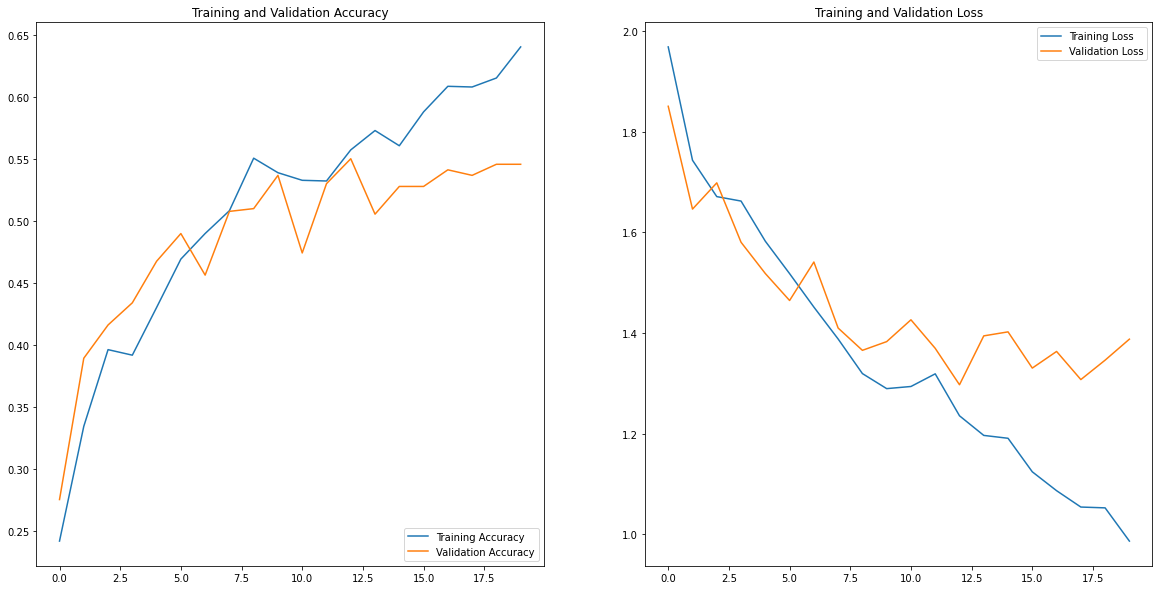

In [23]:
def visualizeResults(history, train_epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(train_epochs)

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    return acc, val_acc
acc1, val_acc1 = visualizeResults(history1, model1_epochs)

In [24]:
print("\033[1mTrain Accuracy\033[0m after {0} epochs: \033[1m{1:.2f}\033[0m".format(model1_epochs,max(acc1)*100))
print("\033[1mValidation Accuracy\033[0m after {0} epochs: \033[1m{1:.2f}\033[0m".format(model1_epochs,max(val_acc1)*100))

Train Accuracy after 20 epochs: 64.06
Validation Accuracy after 20 epochs: 55.03


### Findings

- Observing above graphs we can conclude that model ***Overfits*** to some degree, as the training accuracy is about ***64%*** and validation accuracy is approximately ***55%***.
- The mode seems to be learning well but is overfitting as there is ***9%*** difference in training and validation.
- It could be due to class imbalance or model is just learning noise. We need to add more data for it to generalise better. We might also use dropout to prevent noise leaking into model. 

## 5. Data Augmentation

- As the model is overfitting, we will use data augmentation strategy to generate more data to improve the model performance as mentioned in findings of Model 1.
- Since the classification is not constrained by the lighting or orientation or size of the infected area following data augmentation strategies can used. 
    - Flips (Vertical and Horizontal)
    - Rotation (Various degrees)
    - Zooming
    - Contrast variation
- We will be using random transformations package for this.

In [25]:
augument_data = Sequential([
    RandomFlip('horizontal_and_vertical'),
    RandomRotation((-0.1, 0.1)), 
    RandomZoom(0.2),
    RandomContrast(0.05)])

#### Visualizing how our augmentation strategy works for one instance of training image

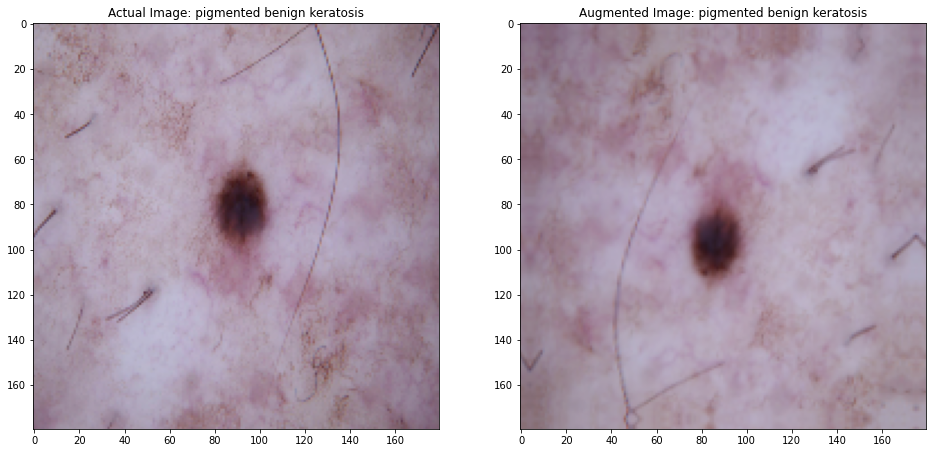

In [26]:
plt.figure(figsize=(16, 8))
for images, labels in train_ds.take(1):
    image = images[0]
    label = tf.keras.backend.get_value(labels[0])
    
    ax = plt.subplot(1, 2, 1)
    plt.imshow(image.numpy().astype('uint8'))
    plt.title("Actual Image: " + class_names[label])

    ax = plt.subplot(1, 2, 2)
    image_aug = augument_data(tf.cast(image, tf.float32))
    plt.imshow(image_aug.numpy().astype('uint8'))
    plt.title("Augmented Image: " + class_names[label])
    
    plt.show()
    break

## 6. Model Building and Training - Model 2 - Base CNN Model with dropout and Data Augumentation

### Creating second CNN model, which aims to accurately detect 9 classes present in the dataset. 

#### Model definition

- Rescaling of input values between 0 and 1 (as RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network.)
- Data Augumentation layer
- Shallow CNN network with ***3 CNN*** blocks and ***2 Fully Connected(FC)*** layers
- Each CNN block has ***2 CNN*** layers, and each layer is followed by a ***Maxpooling layer*** and a ***Dropout layer***
- ***Relu*** activation is used in CNN layers
- ***Softmax*** function is used at the last FC layer 

In [27]:
model2 = Sequential()

model2.add(Rescaling(1./255, input_shape = input_shape))

model2.add(augument_data)


model2.add(Conv2D(32, 3, padding='same',  activation='relu'))
model2.add(MaxPool2D(2,2))
model2.add(Dropout(0.25))

model2.add(Conv2D(32, 3, padding='same',  activation='relu'))
model2.add(MaxPool2D(2,2))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, 3, padding='same',  activation='relu'))
model2.add(MaxPool2D(2,2))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, 3, padding='same',  activation='relu'))
model2.add(MaxPool2D(2,2))
model2.add(Dropout(0.25))


model2.add(Conv2D(128, 3, padding='same',  activation='relu'))
model2.add(MaxPool2D(2,2))
model2.add(Dropout(0.25))

model2.add(Conv2D(128, 3, padding='same',  activation='relu'))
model2.add(MaxPool2D(2,2))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(1000, activation='relu'))
model2.add(Dense(class_count, activation='softmax'))

### Compiling the model

Choosing an appropirate optimiser and loss function for model training 

- ***Adam*** optimizer is used for ***optimizer*** setting
- ***Sparse Categorical CrossEntropy*** is used as ***loss function*** since its multi-class classification problem
- ***Accuracy*** is used as the ***performance*** metrics

In [28]:
model2.compile(optimizer='adam',
              loss=losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [29]:
# View the summary of all layers
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (180, 180, 3)             0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        9248      
                                                      

### Training the model

Training for ***20 epochs***

In [30]:
## %%time
model2_epochs = 20
history2 = model2.fit(train_ds,
                      validation_data=val_ds,
                      epochs=model2_epochs)

Epoch 1/20
56/56 [==============================] - 6s 76ms/step - loss: 2.0589 - accuracy: 0.1908 - val_loss: 2.0377 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 4s 75ms/step - loss: 2.0195 - accuracy: 0.1892 - val_loss: 2.0481 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 4s 74ms/step - loss: 2.0066 - accuracy: 0.2115 - val_loss: 2.0594 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 4s 74ms/step - loss: 2.0032 - accuracy: 0.2137 - val_loss: 1.9875 - val_accuracy: 0.2327
Epoch 5/20
56/56 [==============================] - 4s 74ms/step - loss: 1.8872 - accuracy: 0.2857 - val_loss: 1.8187 - val_accuracy: 0.2953
Epoch 6/20
56/56 [==============================] - 4s 74ms/step - loss: 1.8003 - accuracy: 0.3119 - val_loss: 1.7911 - val_accuracy: 0.3870
Epoch 7/20
56/56 [==============================] - 4s 75ms/step - loss: 1.6904 - accuracy: 0.3694 - val_loss: 1.7724 - val_accuracy: 0.3266
Epoch 8/20
56

### Visualizing the results

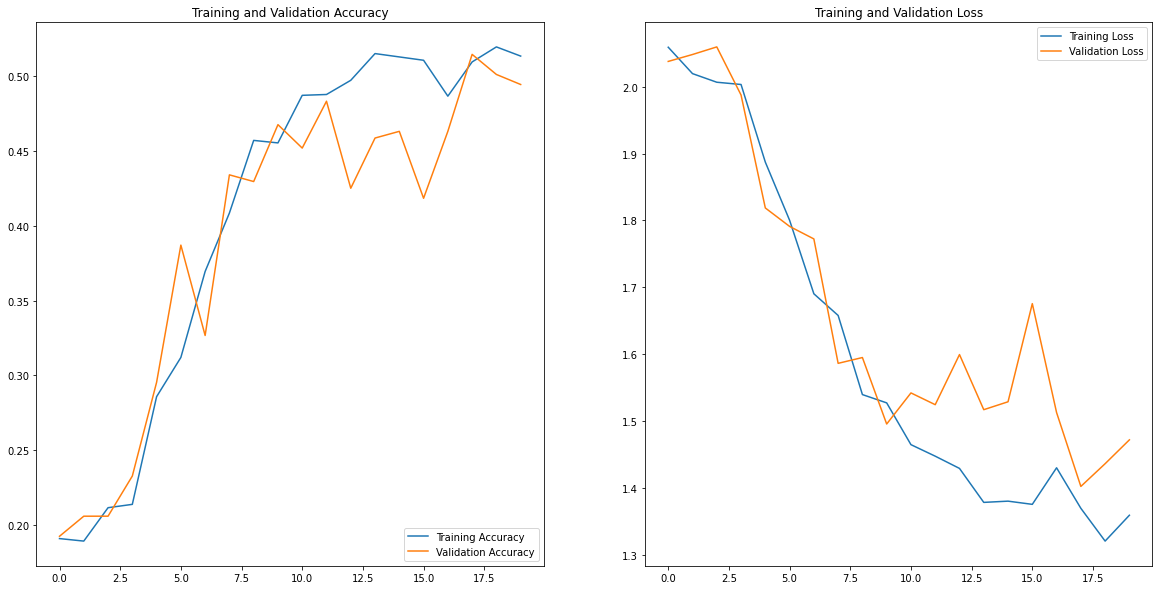

In [31]:
acc2, val_acc2 = visualizeResults(history2, model2_epochs)

In [32]:
print("\033[1mTrain Accuracy\033[0m after {0} epochs: \033[1m{1:.2f}\033[0m".format(model2_epochs,max(acc2)*100))
print("\033[1mValidation Accuracy\033[0m after {0} epochs: \033[1m{1:.2f}\033[0m".format(model2_epochs,max(val_acc2)*100))

Train Accuracy after 20 epochs: 51.95
Validation Accuracy after 20 epochs: 51.45


### Findings

- The training accuracy is about ***52%*** and validation accuracy is approximately ***51.5%*** indicating that dropouts and data augumentation has helped closing the gap and preventing overfits.
- Both validation and training accuracy went down but the gap closed means we were able to remove some level of overfitting.
- Since training accuracy itself is dropped that means its has started to underfit, hence adding more data should help in improving the model.

## 7. Examine Class Distribution in Training data set

Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

{'actinic keratosis': 114, 'basal cell carcinoma': 376, 'dermatofibroma': 95, 'melanoma': 438, 'nevus': 357, 'pigmented benign keratosis': 462, 'seborrheic keratosis': 77, 'squamous cell carcinoma': 181, 'vascular lesion': 139}


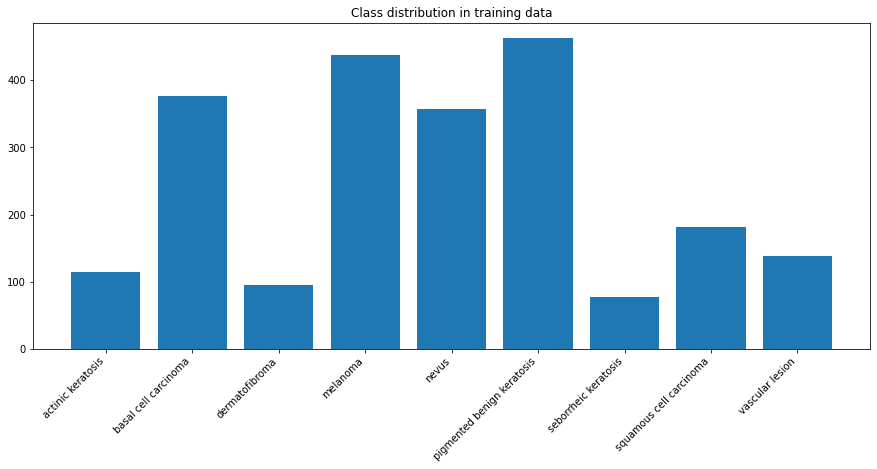

In [33]:
class_distribution = {}
for cls in class_names:
    path = pathlib.Path(os.path.join(train_folder_path, cls))
    count = len(list(path.glob('*.jpg')))
    class_distribution[cls]=count
print(class_distribution)

plt.figure(figsize=(15, 6))
plt.bar(list(class_distribution.keys()), list(class_distribution.values()))
plt.title("Class distribution in training data")
plt.xticks(rotation = 45, ha = 'right');

### Findings

- Class 6(seborrheic keratosis) have least samples of all i.e. 77
- Class 5(pigmented benign keratosis) dominate in terms of proportionate number of samples  i.e. 462
- Dataset is quite imbalanced


## 8. Handling class imbalances

- It is improtant to have class balance for better infering the performance of the model.
- Having good amount of data, helps the model to learn the useful features and improve the prediction power of the model. 
- We will use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.
- This will help us tackle the class imbalance issue and increase input data volume for better modelling.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [35]:
path_to_training_dataset=train_folder_path
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + '/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD054AEBA60>: 100%|██████████| 500/500 [00:02<00:00, 221.34 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD054B81AC0>: 100%|██████████| 500/500 [00:02<00:00, 220.80 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD054B6A400>: 100%|██████████| 500/500 [00:02<00:00, 219.20 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FCFDAEE8DF0>: 100%|██████████| 500/500 [00:12<00:00, 39.63 Samples/s]                    


Initialised with 357 image(s) found.
Output directory set to Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7FCFA80C4AC0>: 100%|██████████| 500/500 [00:10<00:00, 48.95 Samples/s]                  


Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FCF9069C7C0>: 100%|██████████| 500/500 [00:02<00:00, 226.22 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FCFA80C9850>: 100%|██████████| 500/500 [00:05<00:00, 87.97 Samples/s]                   


Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCFA9D61880>: 100%|██████████| 500/500 [00:02<00:00, 210.32 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCFA9E49580>: 100%|██████████| 500/500 [00:02<00:00, 209.82 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [36]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [37]:
## path of individual images from new data

path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(path_list_new)

4500

In [38]:
## classnames for individual images from new data

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(lesion_list_new)

4500

In [39]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [40]:
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [41]:
new_df['Label'].value_counts()

squamous cell carcinoma       500
pigmented benign keratosis    500
nevus                         500
vascular lesion               500
melanoma                      500
actinic keratosis             500
seborrheic keratosis          500
dermatofibroma                500
basal cell carcinoma          500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## 9. Model Building and Training - Model 3 - Base CNN Model with Balanced Class Data



### Creating augmented training dataset

In [42]:
train_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=seed,
  validation_split = validation_split,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Creating augumented validation dataset

In [43]:
val_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=seed,
  validation_split = validation_split,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Creating third CNN model, which aims to accurately detect 9 classes present in the dataset. 

#### Model definition

- Rescaling of input values between 0 and 1 (as RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network.)
- Shallow CNN network with ***3 CNN*** blocks and ***2 Fully Connected(FC)*** layers
- Each CNN block has ***2 CNN*** layers,and each layer is followed by a ***Batch Normalization layer***, a ***Maxpooling layer*** and a ***Dropout layer***
- ***Relu*** activation is used in CNN layers
- ***Softmax*** function is used at the last FC layer 


In [44]:
model3 = Sequential()

model3.add(Rescaling(1./255, input_shape = input_shape))

model3.add(Conv2D(32, 3, padding='same',  activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPool2D(2,2))
model3.add(Dropout(0.25))

model3.add(Conv2D(32, 3, padding='same',  activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPool2D(2,2))
model3.add(Dropout(0.25))

model3.add(Conv2D(64, 3, padding='same',  activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPool2D(2,2))
model3.add(Dropout(0.25))

model3.add(Conv2D(64, 3, padding='same',  activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPool2D(2,2))
model3.add(Dropout(0.25))

model3.add(Conv2D(128, 3, padding='same',  activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPool2D(2,2))
model3.add(Dropout(0.25))

model3.add(Conv2D(128, 3, padding='same',  activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPool2D(2,2))
model3.add(Dropout(0.25))

model3.add(Flatten())
model3.add(Dense(1000, activation='relu'))
model3.add(Dense(class_count, activation='softmax'))

### Compiling the model

Choosing an appropirate optimiser and loss function for model training 

- ***Adam*** optimizer is used for ***optimizer*** setting
- ***Sparse Categorical CrossEntropy*** is used as ***loss function*** since its multi-class classification problem
- ***Accuracy*** is used as the ***performance*** metrics

In [45]:
model3.compile(optimizer='adam',
              loss=losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [46]:
# View the summary of all layers
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)       

### Training the model

Training for ***30 epochs***

In [47]:
%%time
model3_epochs = 30
history3 = model3.fit(train_ds_aug,
                      validation_data=val_ds_aug,
                      epochs=model3_epochs)

Epoch 1/30
169/169 [==============================] - 10s 53ms/step - loss: 1.8027 - accuracy: 0.3683 - val_loss: 3.5961 - val_accuracy: 0.1663
Epoch 2/30
169/169 [==============================] - 9s 50ms/step - loss: 1.3384 - accuracy: 0.4898 - val_loss: 3.7523 - val_accuracy: 0.1151
Epoch 3/30
169/169 [==============================] - 9s 50ms/step - loss: 1.1897 - accuracy: 0.5504 - val_loss: 3.0882 - val_accuracy: 0.2264
Epoch 4/30
169/169 [==============================] - 9s 50ms/step - loss: 1.0941 - accuracy: 0.5844 - val_loss: 2.4578 - val_accuracy: 0.3326
Epoch 5/30
169/169 [==============================] - 9s 50ms/step - loss: 0.9711 - accuracy: 0.6293 - val_loss: 1.7559 - val_accuracy: 0.4543
Epoch 6/30
169/169 [==============================] - 9s 50ms/step - loss: 0.8970 - accuracy: 0.6534 - val_loss: 1.7837 - val_accuracy: 0.4180
Epoch 7/30
169/169 [==============================] - 9s 50ms/step - loss: 0.8042 - accuracy: 0.6931 - val_loss: 1.3405 - val_accuracy: 0.530

### Visualizing the results

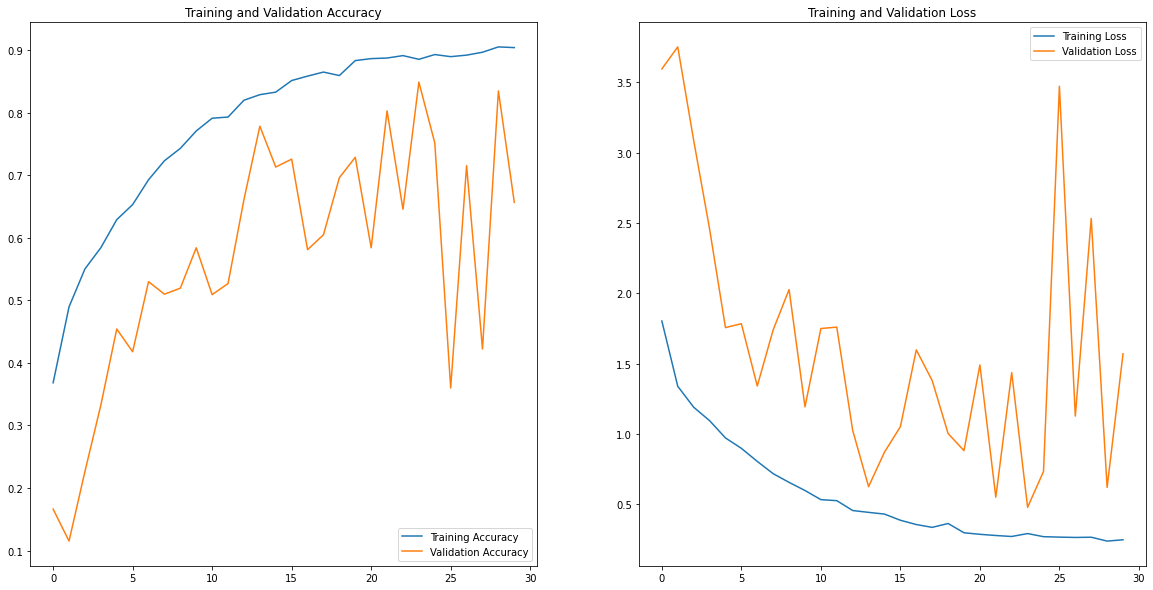

In [48]:
acc3, val_acc3 = visualizeResults(history3, model3_epochs)

In [49]:
print("\033[1mTrain Accuracy\033[0m after {0} epochs: \033[1m{1:.2f}\033[0m".format(model3_epochs,max(acc3)*100))
print("\033[1mValidation Accuracy\033[0m after {0} epochs: \033[1m{1:.2f}\033[0m".format(model3_epochs,max(val_acc3)*100))

Train Accuracy after 30 epochs: 90.56
Validation Accuracy after 30 epochs: 84.93


### Findings

- With class rebalance and more epochs we got tremendous improvements.

- We can add more data and layers to further improve the performance.

- The ***training and validation accuracy*** to has got to ***decent levels***.
